In [8]:
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from torchvision.io import read_image

In [11]:
DATA_DIR = "/workspace/computer-vision/pytorch_study/data/PennFudanPed/"
IMAGE_DIR = "/workspace/computer-vision/pytorch_study/data/PennFudanPed/PNGImages/"
MASK_DIR = "/workspace/computer-vision/pytorch_study/data/PennFudanPed/PedMasks/"

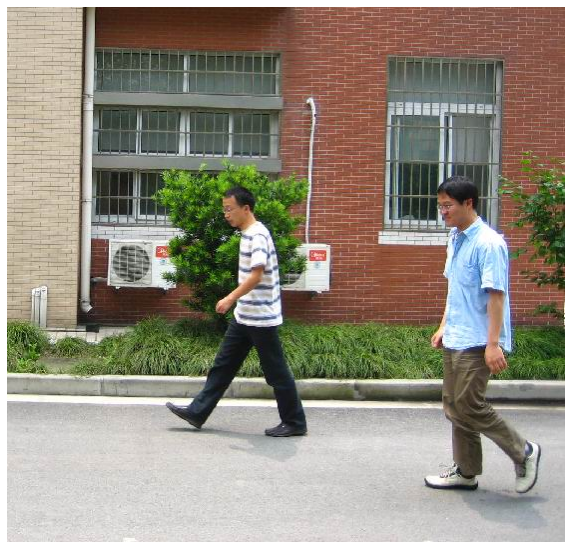

In [3]:
img = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, "FudanPed00001.png")), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [4]:
mask = cv2.imread(os.path.join(MASK_DIR, "FudanPed00001_mask.png"))
mask.shape

(536, 559, 3)

In [5]:
COLORMAP = np.array([
    [0, 0, 0],
    [255, 0, 0],
    [255, 255, 0],
    [255, 153, 0],
])

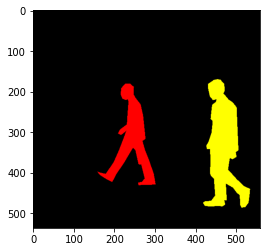

In [6]:
plt.imshow(COLORMAP[mask[..., 0]])
plt.show()

In [ ]:
class PennFudanDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transforms=None):
        self.imgs = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transforms = transforms

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
"""
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label"""